# Process
In this notebook, I will analyze the dataset it and prepare it for training of Recommender systems.

## A. Import Libraries

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import read_popularity, users_and_items, user_distribution,item_distribution, calculate_popularity, calculate_group_characteristics, calculate_gini_coefficient
from plots import plot_data_distribution, plot_popularity_distribution, plot_profile_size_vs_popularity, plot_group_characteristics, plot_Lorenz
import tqdm 
from split_users import sort_user_dist, split, split_differently
import time
import pickle as pkl
from sklearn.model_selection import train_test_split
pd.set_option("display.precision", 5)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [23]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [24]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

In [25]:
print(addition_4)

_u5_i5_t200_tfi20_tfu20_sbpf


In [26]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [27]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

In [28]:
user_events_file = raw_file_location + "ratings_books.csv" # the ratings file
user_file = raw_file_location + "users_books.csv" # the users file
item_file = raw_file_location + "items_books.csv" # the items file

In [29]:
cols = ["user", "book", "rating"] # columns in the ratings dataset
df_events = pd.read_csv(user_events_file, names=cols, header=0, low_memory=False)
print('No. of user events (i.e. ratings): ' + str(len(df_events)))

No. of user events (i.e. ratings): 1149780


In [30]:
df_events.head()

,user,book,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [31]:
df_books = pd.read_csv(item_file, low_memory=False)
df_users = pd.read_csv(user_file, low_memory=False)

## D. Preprocess data
1. Convert book IDs into numbers (needed for Cornac).
2. Remove implicit ratings.
3. Remove users with too many ratings.
4. Remove users and items with only few ratings.


### Drop Implicit Ratings

In [32]:
# DROP IMPLICIT RATINGS
df_events = df_events.loc[df_events.rating!=0] # the 0 in this dataset signifies implicit rating and should not be taken into account.

In [33]:
#df_events = df_events[df_events.book.isin(df_books.ISBN)] # I am keeping only the ratings of items that exist in the items dataset

In [34]:
users_and_items(df_events, "user", item_col) # print properties of the ratings set
user_dist, num_users = user_distribution(df_events, "user", item_col, prnt = True) # create dataset for all users 
item_dist, num_items = item_distribution(df_events, "user", item_col, prnt = True) # create dataset for all items

No. user events: 433671
No. items: 185973
No. users: 77805


Mean books per user: 5.6
Min books per user: 1
Max books per user: 8524


Mean users per book: 2.3
Min users per book: 1
Max users per book: 707




### Remove users with more than top_threshold ratings

In [35]:
user_dist = user_dist[user_dist < top_threshold] # remove all users with less than top_threshold items
df_events = df_events[df_events.user.isin(user_dist.index)].reset_index().drop("index", axis=1) # remove these users from the ratings set
users_and_items(df_events, "user", item_col) # print properties of the ratings set
user_dist, num_users = user_distribution(df_events, "user", item_col, prnt=True) # update dataset for all users 
item_dist, num_items = item_distribution(df_events, "user", item_col, prnt=True) # update dataset for all items 

No. user events: 364245
No. items: 156891
No. users: 77660


Mean books per user: 4.7
Min books per user: 1
Max books per user: 199


Mean users per book: 2.3
Min users per book: 1
Max users per book: 683




### Remove users and items with less than item_threshold and user_threshold ratings respectively


In [36]:
# remove items and users iteratively until there are only users with at least item_threshold items and items with at least user_threshold users.
while item_dist.iloc[-1] < user_threshold  or user_dist.iloc[-1] < item_threshold:
    item_dist = item_dist[item_dist >= user_threshold]
    user_dist = user_dist[user_dist >= item_threshold]
    df_events = df_events[df_events.user.isin(user_dist.index)].reset_index().drop("index", axis=1)
    df_events = df_events[df_events[item_col].isin(item_dist.index)].reset_index().drop("index", axis=1)
    user_dist, num_users = user_distribution(df_events, "user", item_col) # update dataset for all users 
    item_dist, num_items = item_distribution(df_events, "user", item_col) # update dataset for all items

### Convert book IDs into numbers

In [37]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in df_events.book.unique():
    mapping_dict[ISBN] = i
    i+=1
# Save the mapping dictionary
with open(processed_file_location + recommendation_type + "/map_ISBN_to_int.pkl", "wb") as f:
    pkl.dump(mapping_dict, f)
df_events.book = df_events.book.map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file
df_books.ISBN = df_books.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file
items_with_properties.ISBN = items_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file
# Save the books df with the new "ISBNs"
df_books.to_csv(processed_file_location + recommendation_type + "/items_books_mapped.csv")
# Save the books df with the new "ISBNs"
items_with_properties.to_csv(processed_file_location + recommendation_type + "/items_books_mapped_with_properties.csv")

In [38]:
print("Final data distribution:")
user_dist, num_users = user_distribution(df_events, "user", item_col, prnt=True) 
item_dist, num_items = item_distribution(df_events, "user", item_col, prnt=True)
users_and_items(df_events, "user", item_col) # print final properties of ratings set

Final data distribution:
Mean books per user: 13.9
Min books per user: 5
Max books per user: 153


Mean users per book: 12.8
Min users per book: 5
Max users per book: 350


No. user events: 88552
No. items: 6921
No. users: 6358




Finally, we create an dataframe of the item characteristics that contains item popularity.

In [39]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item

In [40]:
df_item_dist.head()

,count
124,0.05505
70,0.04357
50,0.03130
465,0.02957
581,0.02831


In [41]:
train_test_split(df_events,test_size=0.2, train_size=0.8, random_state=0)[1][:5].sort_values(by="rating",ascending=False)

,user,book,rating
69061,220931,6165,10
13692,43910,4197,9
66341,211231,1094,8
66454,211426,5131,8
58367,185140,3508,6


## E. Measure diversity in data

### Gini Coefficient
Reference: https://dl.acm.org/doi/pdf/10.1145/1250910.1250939, Section 3.1

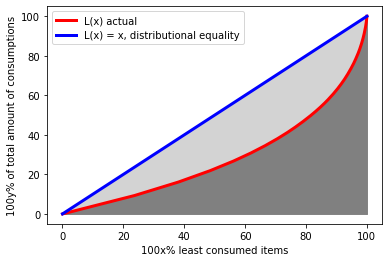

The Gini Coefficient in the data is:  0.43


In [42]:
# GINI COEFFICIENT
GC, movs, data_cdf = calculate_gini_coefficient(item_dist) # calculate gini coefficient
plot_Lorenz(movs,data_cdf, save = True, item_col=item_col, addition = addition_1) # plot lorenz curve in data
print("The Gini Coefficient in the data is: ", np.round(GC,3))

## F. Define and Calculate Popularity
An item is popular = It is among the top_fraction_items most popular items.

In [43]:
num_top = int(top_fraction_items * num_items) # choose the top_fraction_items most popular items
top_item_dist = item_dist[:num_top] #item_dist is already sorted by count, so top_item_dist is the item distribution of the "popular" items
print('No. popular items: ' + str(len(top_item_dist)))

No. popular items: 1384


In [44]:
# get pop fractions for every user
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, "user", item_col) # calculate profile size, fraction of popular items, average popularity and number of popular items for all users.
#pop_count,user_hist,pop_fraq, pop_item_fraq = read_popularity(item_col)

1000
2000
3000
4000
5000
6000


## G. Plot distribution of data and popularity

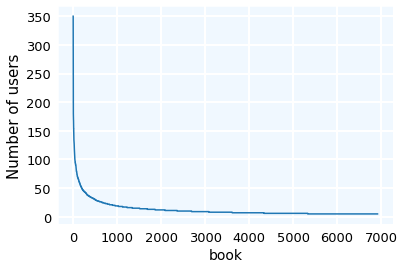

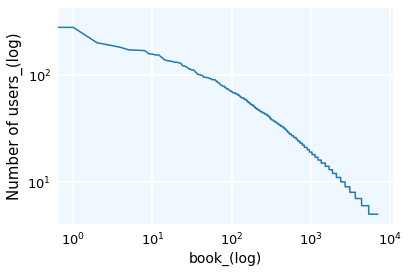

In [45]:
plot_data_distribution(item_dist, item_col, save = True, addition = addition_1) # item vs number of users
plot_data_distribution(item_dist, item_col, [False, 0],True, save = True, addition = addition_1) # item vs number of users - log scale

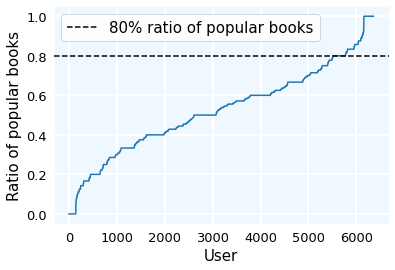

R-value: 0.9230435903359985


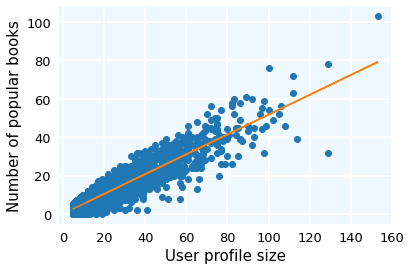

R-value: -0.013155544625724318


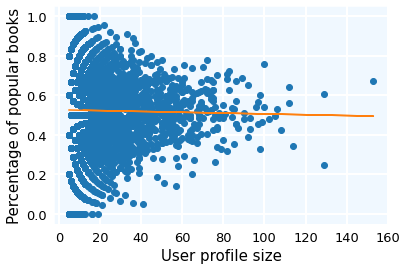

R-value: -0.033575222226251665


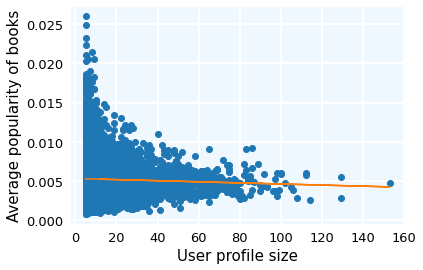

In [46]:
plot_popularity_distribution(pop_fraq, item_col, save = True, addition = addition_2) # distribution of popularity among items
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col, save = True, addition = addition_2) # number of popular vs profile size
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col, save = True, addition = addition_2) # fraction of popular vs profile size
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col, save = True, addition = addition_1) #  average popularity vs profile size

## H. Divide user groups
Divide users based on a: [top_fraction_items, 100%-2*top_fraction_items, top_fraction_items] scheme. (e.g. 20%-60%-20%).

Note 1. The users are sorted based on "split_by".

Note 2. GAP is a metric for average popularity of items in a group's users' profiles.

Note 3. MS = Mainstreaminess.

In [47]:
# Divide Users based on split_by

user_dist_sorted = sort_user_dist(user_dist, pop_count, user_hist, pop_fraq, pop_item_fraq, by = split_by)
low, med, high = split(user_dist_sorted, top_fraction_items)

low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)
print('LowMS GAP: ' + str(low_GAP))
print('MedMS GAP: ' + str(med_GAP))
print('HighMS GAP: ' + str(high_GAP))

LowMS GAP: 0.002617994538853091
MedMS GAP: 0.005115376310090791
HighMS GAP: 0.008074644552000734


## I. Plot group characteristics
Note: Plot popularity distribution among groups only applicable when dividing by pop_fraq.

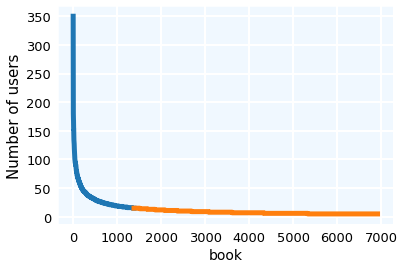

The blue items are the 'popular' ones.


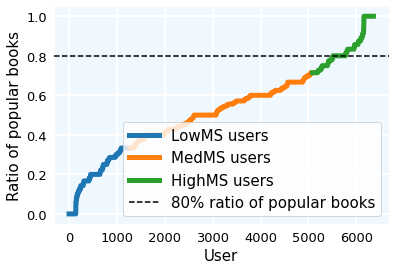

In [48]:
plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction_items], log = False, save = True, addition = addition_2)
print("The blue items are the 'popular' ones.")
plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction_items], save = True, addition = addition_3)

Low: 1271
Med: 3815
High: 1272


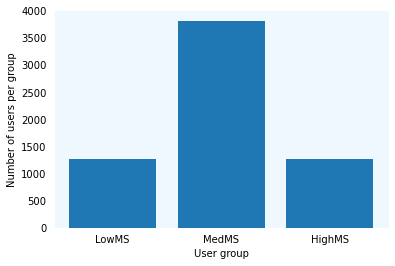

Low: 10.991345397324942
Med: 16.222804718217564
High: 9.977987421383649


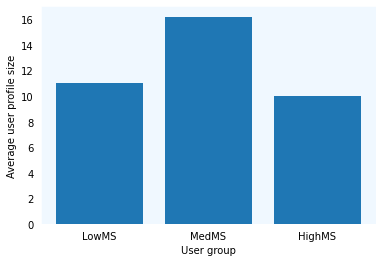

In [49]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col, save = True, addition = addition_4)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col, save = True, addition = addition_4)

## J. Save Processed Data
Now we will save all the files that are needed for training the Recommender Systems and analyzing the results.
1. The processed ratings file df_events
2. The LowMS, MedMS and HighMS users.
3. The item popularity dataframe df_item_dist.
4. The GAP of LowMS, MedMS & HighMS.

(We have already saved the "mapped" files.

In [50]:
df_events.to_csv(processed_file_location +recommendation_type +"/ratings"+addition_1+".csv", index=False)

In [51]:
low.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_4+".csv")
med.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_4+".csv")
high.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_4+".csv")

In [52]:
df_item_dist.to_csv(processed_file_location +recommendation_type + "/item_pop_dist"+addition_1+".csv")

In [53]:
GAP_list = [low_GAP, med_GAP, high_GAP]
with open(processed_file_location+recommendation_type+"/GAP_list"+addition_4+".pkl", "wb") as f:
    pkl.dump(GAP_list, f)